In [1]:
#Tasks - Module 8 -- Time Series Analysis

#Loading necessary packages

import pandas as pd
import numpy as np
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pandas import Series
import statsmodels.api as sm
from scipy import stats
from matplotlib.dates import DateFormatter
import scipy.stats as scp
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn import preprocessing

In [2]:
#Task 1

#Reading in the necessary dataset
NMFS_Landings = pd.read_csv("NMFS_Landings.csv", parse_dates=True, dayfirst=True)

#Selecting only necessary columns
NMFS_Landings = NMFS_Landings[['Year','Month','Metric_Tons']]

#Recreating the Time in proper date format
NMFS_Landings['Time'] = '01/' + NMFS_Landings['Month'].astype(str)+'/'+NMFS_Landings['Year'].astype(str)

NMFS_Landings.describe()

,Year,Metric_Tons
count,300.000000,300.000000
mean,2003.000000,210618.007667
std,7.223151,157103.550719
min,1991.000000,26196.700000
25%,1997.000000,81970.700000
50%,2003.000000,185751.700000
75%,2009.000000,264308.325000
max,2015.000000,788204.100000


In [3]:
#Converting Time column to Datetime64 type
NMFS_Landings['Time']=pd.to_datetime(NMFS_Landings['Time'], format='%d/%b/%Y')

NMFS_Landings = NMFS_Landings.sort_values(by='Time')
NMFS_Landings

,Year,Month,Metric_Tons,Time
0,1991,Jan,351326.5,1991-01-01
25,1991,Feb,331531.5,1991-02-01
50,1991,Mar,239503.0,1991-03-01
75,1991,Apr,229840.5,1991-04-01
100,1991,May,278048.7,1991-05-01
...,...,...,...,...
199,2015,Aug,241211.8,2015-08-01
224,2015,Sep,214366.8,2015-09-01
249,2015,Oct,165268.8,2015-10-01
274,2015,Nov,66215.2,2015-11-01


In [4]:
#Sorting the dataframe by Time column to arrange in chronological order

NMFS_Landings = NMFS_Landings[['Metric_Tons', 'Time']]

#Setting the index of the dataframe to the Time column
NMFS_Landings.set_index('Time', inplace=True)
#There is no need to convert the column to ts object as in R - setting to index would suffice

NMFS_Landings.sort_values(by='Time')

,Metric_Tons
Time,
1991-01-01,351326.5
1991-02-01,331531.5
1991-03-01,239503.0
1991-04-01,229840.5
1991-05-01,278048.7
...,...
2015-08-01,241211.8
2015-09-01,214366.8
2015-10-01,165268.8


In [5]:
NMFS_Landings.head()

,Metric_Tons
Time,
1991-01-01,351326.5
1991-02-01,331531.5
1991-03-01,239503.0
1991-04-01,229840.5
1991-05-01,278048.7


/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


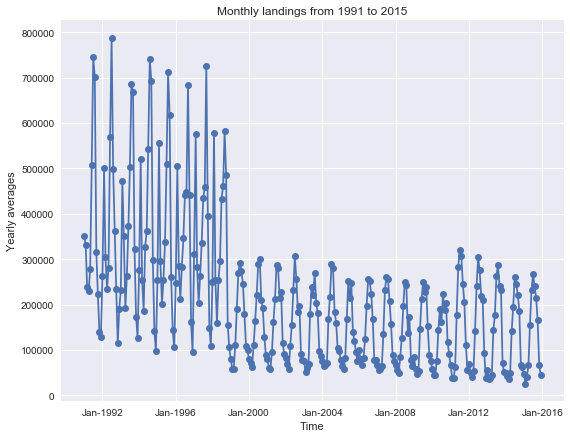

In [6]:
#Plotting the time series data

plt.style.use('seaborn')

fig,ax=plt.subplots(figsize=(9,7))
ax.plot(NMFS_Landings.index.values, NMFS_Landings['Metric_Tons'],'-o')
ax.set(xlabel="Time",ylabel="Yearly averages",title="Monthly landings from 1991 to 2015")

#Setting the ticks format on x-axis to months and years
ax.xaxis.set_major_formatter(DateFormatter("%b-%Y"))

# There are two different periods of time that the series are bouncing around two different mean levels. Although there is not a trend for each 
# time period, as a whole the mean level is changing through the time. Seasonality and changing variance are obvious from the series. 
# To see the autocorrelation structure clearly, we need to filtrate out the effect of seasonality.

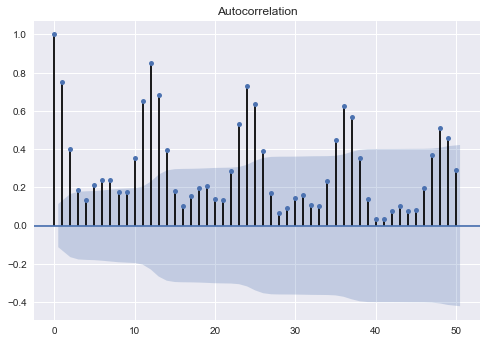

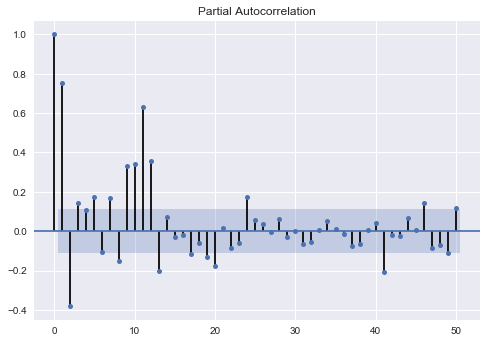

In [7]:
#Creating the ACF and PACF plots of the landings series

sm.graphics.tsa.plot_acf(NMFS_Landings.Metric_Tons, lags=50);
sm.graphics.tsa.plot_pacf(NMFS_Landings.Metric_Tons, lags=50);

# Seasonality and existence of trend are obvious from the ACF and PACF plots

In [8]:
# First fit a plain model with only the first seasonal difference with order D = 1 
# and see if we can get rid of the seasonal trend effect
# by inspecting the autocorrelation structure of the residuals.

model1=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings['Metric_Tons'],order=(0,0,0),seasonal_order=(0,1,0,12),trend='ct',enforce_invertibility=False)
results1=model1.fit()
print(results1.summary())

                            Statespace Model Results                            
Dep. Variable:              Metric_Tons   No. Observations:                  300
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood               -3612.321
Date:                  Tue, 18 Feb 2020   AIC                           7230.642
Time:                          00:41:17   BIC                           7241.631
Sample:                      01-01-1991   HQIC                          7235.046
                           - 12-01-2015                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.691e+04   7338.857     -2.304      0.021   -3.13e+04   -2528.244
drift         51.0276     67.135      0.760      0.447     -80.555     182.610
sigma2      4.592e+09   1.47e+08    

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


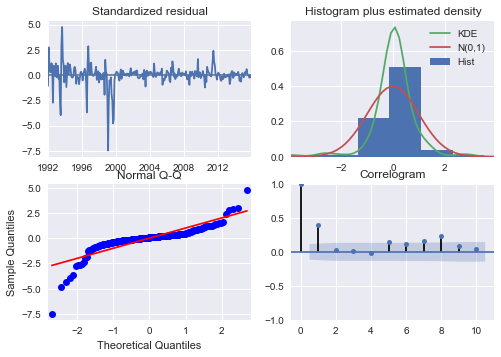

In [9]:
#SARIMAX has an automatic method called plot_diagnostics to get the diagnostic plots for the residuals

results1.plot_diagnostics();

In [10]:
#Getting the residuals for the fitted SARIMA model
residuals1 = pd.DataFrame(results1.resid)

#Standardising the residuals for plotting
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fitting the data on the scaler object to get the standardised residuals
scaled_df1 = pd.DataFrame(scaler.fit_transform(residuals1))
scaled_df1.head()

,0
0,3.365816
1,3.177438
2,2.301166
3,2.208728
4,2.667014


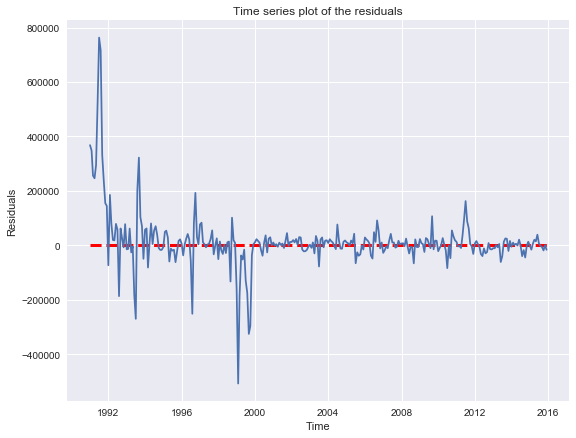

In [11]:
#Plotting the standardised residuals

fig,ax=plt.subplots(figsize=(9,7))

ax.plot(NMFS_Landings.index.values, residuals1,'-')
ax.set(xlabel="Time",ylabel="Residuals",title="Time series plot of the residuals")

#To get the horizontal zero line
xmin=min(NMFS_Landings.index.values)
xmax=max(NMFS_Landings.index.values)
ax.hlines(y=0,xmin=xmin,xmax=xmax,color='red',linestyle='--',lw=3)

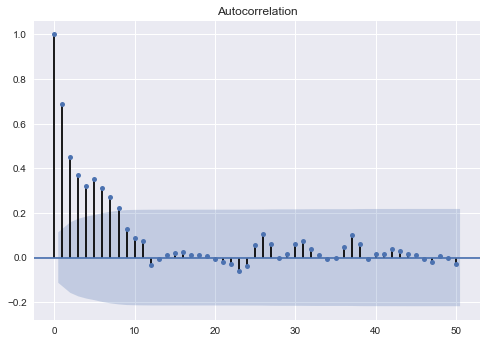

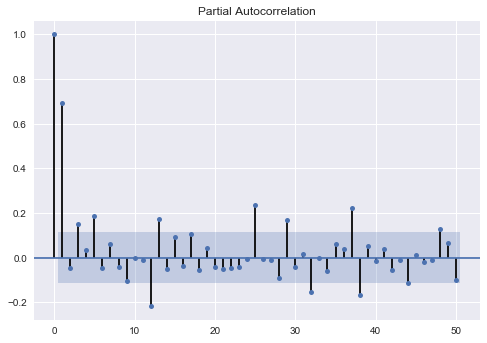

In [12]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(residuals1, lags=50);
sm.graphics.tsa.plot_pacf(residuals1, lags=50);

# From the time series plot, we can conclude that we got rid of the trend. Seasonal autocorrelations are seen clearly in 
# ACF and PACF now at the lags corresponding to the periods. 
# We have one significant correlation at the first seasonal lag in both ACF and PACF.

In [13]:
#So, we will add the SARMA(1,1) component and see if we get rid of seasonal component.

model2=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings['Metric_Tons'],order=(0,0,0),seasonal_order=(1,1,1,12),trend='ct',enforce_invertibility=False)
results2=model2.fit()
print(results2.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                            Statespace Model Results                            
Dep. Variable:              Metric_Tons   No. Observations:                  300
Model:             SARIMAX(1, 1, 1, 12)   Log Likelihood               -3611.860
Date:                  Tue, 18 Feb 2020   AIC                           7233.721
Time:                          00:41:19   BIC                           7252.035
Sample:                      01-01-1991   HQIC                          7241.060
                           - 12-01-2015                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.691e+04    1.9e+04     -0.890      0.373   -5.42e+04    2.03e+04
drift         53.9985    100.383      0.538      0.591    -142.749     250.746
ar.S.L12       0.0523      0.584    

In [14]:
#Getting the residuals for the fitted SARIMA model
residuals2 = pd.DataFrame(results2.resid)

#Standardising the residuals for plotting
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fitting the data on the scaler object to get the standardised residuals
scaled_df = pd.DataFrame(scaler.fit_transform(residuals2))
scaled_df.head()

,0
0,3.369405
1,3.180967
2,2.304391
3,2.211896
4,2.670298


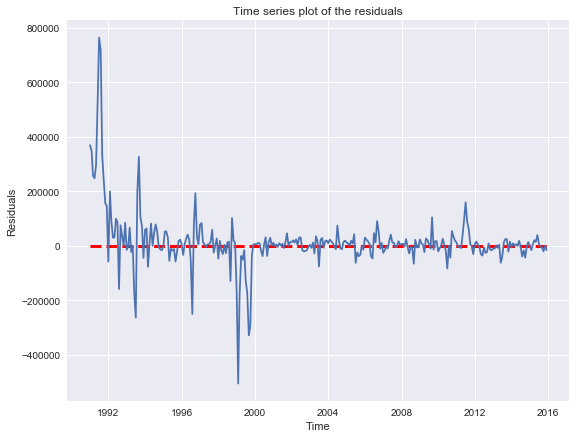

In [15]:
#Plotting the standardised residuals

fig,ax=plt.subplots(figsize=(9,7))

ax.plot(NMFS_Landings.index.values, residuals2,'-')
ax.set(xlabel="Time",ylabel="Residuals",title="Time series plot of the residuals")

#To get the horizontal zero line
xmin=min(NMFS_Landings.index.values)
xmax=max(NMFS_Landings.index.values)
ax.hlines(y=0,xmin=xmin,xmax=xmax,color='red',linestyle='--',lw=3)

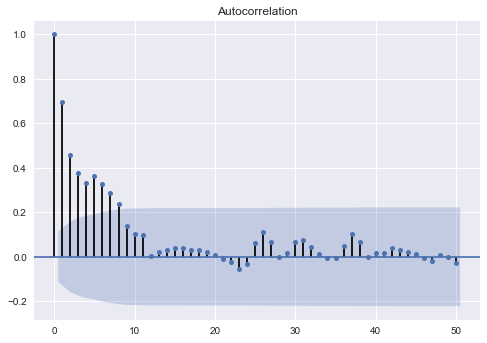

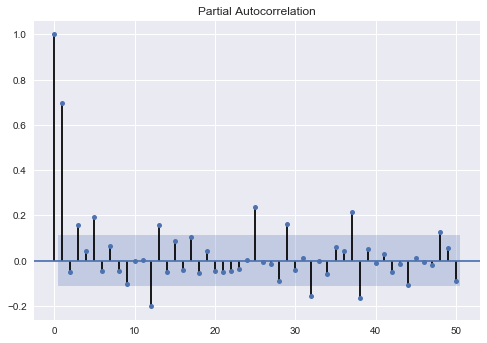

In [16]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(residuals2, lags=50);
sm.graphics.tsa.plot_pacf(residuals2, lags=50);

# Although we have one significant correlation at the first seasonal lag in PACF, we can conclude that 
# the seasonality is filtered out.
# The significant correlation in PACF would be due to the change point in the series.

# Now, we will specify the orders of ARIMA component. The first ordinary correlation in ACF is highly significant, and after a gap, 
# there are four significant correlations before the first seasonal lag. Also, there is a jagged pattern in PACF. This is an indication of
# trend but it's not apparent. This would be due to the highly changing variance. So, it would help to apply a transformation at this stage. 


In [17]:
# So, we will apply the log transformation and see if we can see the trend more clearly.

NMFS_Landings_log = pd.DataFrame(np.log(NMFS_Landings.Metric_Tons))


In [18]:
model3=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings_log['Metric_Tons'],order=(0,0,0),seasonal_order=(1,1,1,12),trend='ct',enforce_invertibility=False)
results3=model3.fit()
print(results3.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                            Statespace Model Results                            
Dep. Variable:              Metric_Tons   No. Observations:                  300
Model:             SARIMAX(1, 1, 1, 12)   Log Likelihood                 -26.591
Date:                  Tue, 18 Feb 2020   AIC                             63.183
Time:                          00:41:20   BIC                             81.497
Sample:                      01-01-1991   HQIC                            70.522
                           - 12-01-2015                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0660      0.041     -1.603      0.109      -0.147       0.015
drift          0.0001      0.000      0.583      0.560      -0.000       0.001
ar.S.L12      -0.0243      0.324    

In [19]:
#Getting the residuals for the fitted SARIMA model
residuals3 = pd.DataFrame(results3.resid)

#Standardising the residuals for plotting
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fitting the data on the scaler object to get the standardised residuals
scaled_df = pd.DataFrame(scaler.fit_transform(residuals3))
scaled_df.head()

,0
0,4.927682
1,4.904499
2,4.774467
3,4.757959
4,4.834032


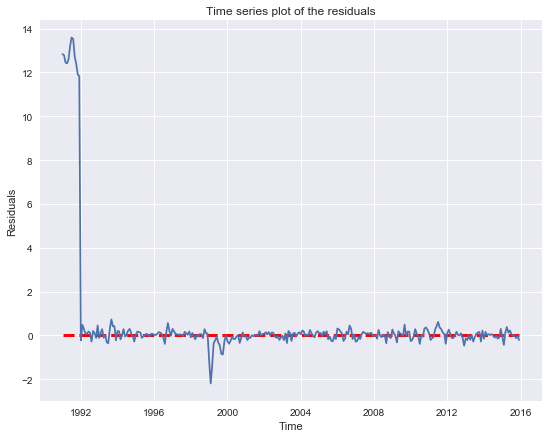

In [20]:
#Plotting the standardised residuals

fig,ax=plt.subplots(figsize=(9,7))

ax.plot(NMFS_Landings.index.values, residuals3,'-')
ax.set(xlabel="Time",ylabel="Residuals",title="Time series plot of the residuals")

#To get the horizontal zero line
xmin=min(NMFS_Landings.index.values)
xmax=max(NMFS_Landings.index.values)
ax.hlines(y=0,xmin=xmin,xmax=xmax,color='red',linestyle='--',lw=3)

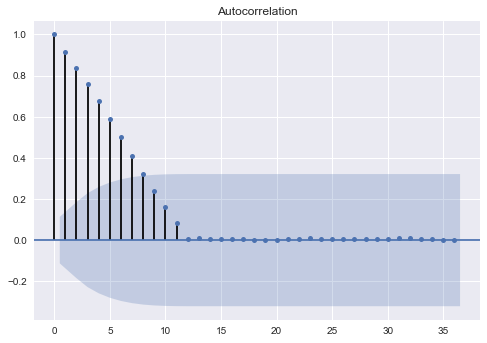

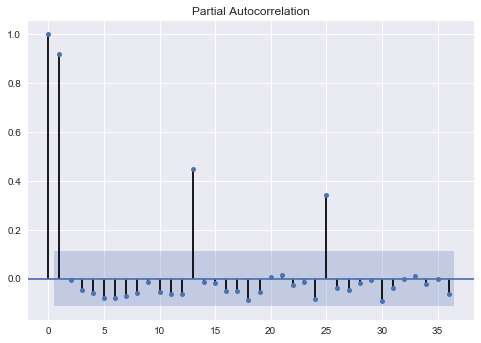

In [21]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(residuals3, lags=36);
sm.graphics.tsa.plot_pacf(residuals3, lags=36);

# The variation in the residuals decreased after the transformation. 
# We have a very high correlation at the first lag of PACF and nearly all the correlations before the first 
# seasonal lag are significant in ACF. So, we need to take the first ordinary difference to get rid of this trend 
# effect before going on with the specification of ARMA orders.

In [22]:
model4=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings_log['Metric_Tons'],order=(0,1,0),seasonal_order=(1,1,1,12),trend='ct',enforce_invertibility=False)
results4=model4.fit()
print(results4.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        Metric_Tons   No. Observations:                  300
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                 -23.916
Date:                            Tue, 18 Feb 2020   AIC                             57.832
Time:                                    00:41:21   BIC                             76.129
Sample:                                01-01-1991   HQIC                            65.165
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0058      0.026      0.223      0.824      -0.045       0.057
drift      -3.746e-05      0.000   

In [23]:
#Getting the residuals for the fitted SARIMA model
residuals4 = pd.DataFrame(results4.resid)

#Standardising the residuals for plotting
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fitting the data on the scaler object to get the standardised residuals
scaled_df = pd.DataFrame(scaler.fit_transform(residuals4))
scaled_df.head()

,0
0,14.994587
1,-0.098270
2,-0.412572
3,-0.078400
4,0.194135


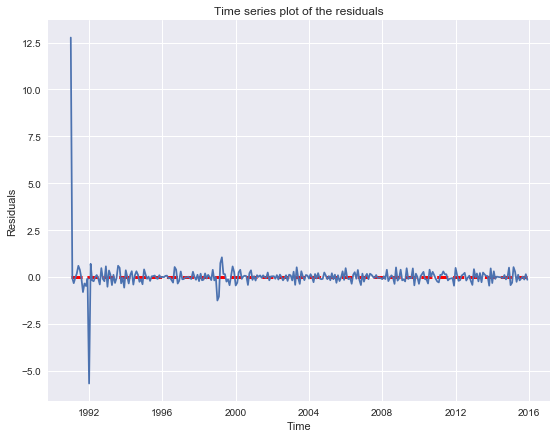

In [24]:
#Plotting the standardised residuals

fig,ax=plt.subplots(figsize=(9,7))

ax.plot(NMFS_Landings.index.values, residuals4,'-')
ax.set(xlabel="Time",ylabel="Residuals",title="Time series plot of the residuals")

#To get the horizontal zero line
xmin=min(NMFS_Landings.index.values)
xmax=max(NMFS_Landings.index.values)
ax.hlines(y=0,xmin=xmin,xmax=xmax,color='red',linestyle='--',lw=3)

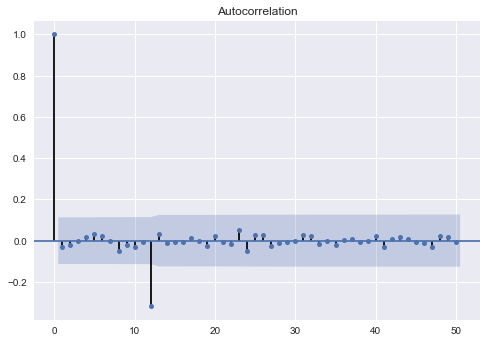

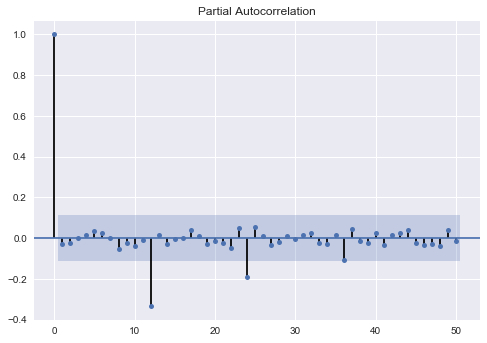

In [25]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(residuals4, lags=50);
sm.graphics.tsa.plot_pacf(residuals4, lags=50);

# In ACF, there is 1 significant lag,  so, we can add MA component up to order 1
# The significant correlations in PACF could be seen as a decreasing pattern or we can set p = 3.


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        Metric_Tons   No. Observations:                  300
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  -5.034
Date:                            Tue, 18 Feb 2020   AIC                             28.069
Time:                                    00:41:23   BIC                             61.004
Sample:                                01-01-1991   HQIC                            41.269
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.022      0.020      0.984      -0.044       0.045
drift      -1.025e-05      0.000   

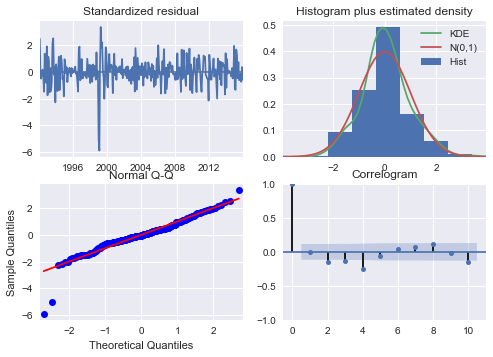

In [26]:
#There is no method to produce EACF plot in Python - so the orders have to be obtained from ACF/PACF.

# The tentative models are specified from the ACF/PACF plots as 
# SARIMA(3,1,1)x(1,1,1)_12
# SARIMA(2,1,1)x(1,1,1)_12
# SARIMA(1,1,1)x(1,1,1)_12
# SARIMA(0,1,1)x(1,1,1)_12
# And for overdifferencing # SARIMA(0,1,2)x(1,1,1)_12 and SARIMA(4,1,1)x(1,1,1)_12 will be fitted

# SARIMA(3,1,1)x(1,1,1)_12
model5_311=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings_log['Metric_Tons'],order=(3,1,1),seasonal_order=(1,1,1,12),trend='ct',enforce_invertibility=False)
results5=model5_311.fit()
print(results5.summary())

#Saving the order, AIC, BIC results
ar1 = results5.model_orders['ar']
ma1 = results5.model_orders['ma']
AIC1 = results5.aic
BIC1 = results5.bic

#Creating a dataframe to hold the results
col_names =  ['p', 'q', 'AIC','BIC']
order_aic_bic1 = pd.DataFrame(columns = col_names)
order_aic_bic1.loc[len(order_aic_bic1)] = [ar1, ma1, AIC1, BIC1]

print(order_aic_bic1)

#Plot residual diagnostics
results5.plot_diagnostics();

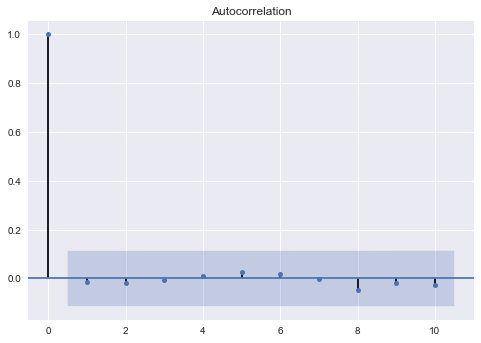

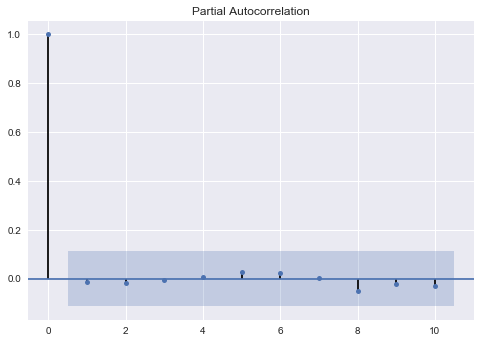

In [27]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(results5.resid, lags=10);
sm.graphics.tsa.plot_pacf(results5.resid, lags=10);

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        Metric_Tons   No. Observations:                  300
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   1.736
Date:                            Tue, 18 Feb 2020   AIC                             12.527
Time:                                    00:41:25   BIC                             41.803
Sample:                                01-01-1991   HQIC                            24.261
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0083      0.009      0.906      0.365      -0.010       0.026
drift      -4.138e-05   4.75e-05   

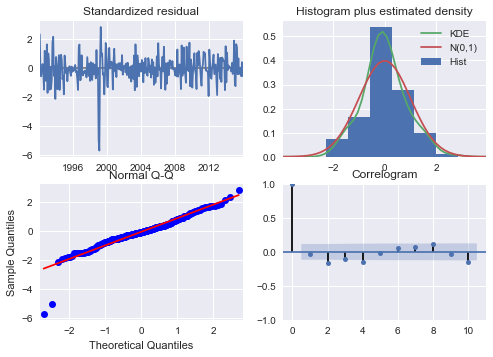

In [28]:
# SARIMA(2,1,1)x(1,1,1)_12

model6_211=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings_log['Metric_Tons'],order=(2,1,1),seasonal_order=(1,1,1,12),trend='ct',enforce_invertibility=False)
results6=model6_211.fit()
print(results6.summary())

#Saving the order, AIC, BIC results
ar2 = results6.model_orders['ar']
ma2 = results6.model_orders['ma']
AIC2 = results6.aic
BIC2 = results6.bic

order_aic_bic1.loc[len(order_aic_bic1)] = [ar2, ma2, AIC2, BIC2]

print(order_aic_bic1)

#Plot residual diagnostics
results6.plot_diagnostics();

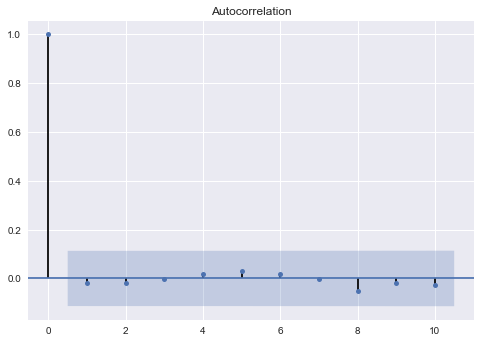

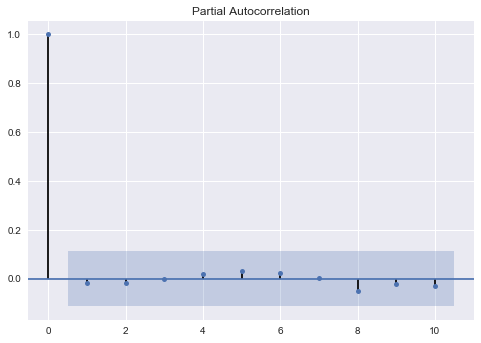

In [29]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(results6.resid, lags=10);
sm.graphics.tsa.plot_pacf(results6.resid, lags=10);

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        Metric_Tons   No. Observations:                  300
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   1.147
Date:                            Tue, 18 Feb 2020   AIC                             11.706
Time:                                    00:41:27   BIC                             37.322
Sample:                                01-01-1991   HQIC                            21.973
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0068      0.008      0.906      0.365      -0.008       0.022
drift      -3.331e-05   3.92e-05   

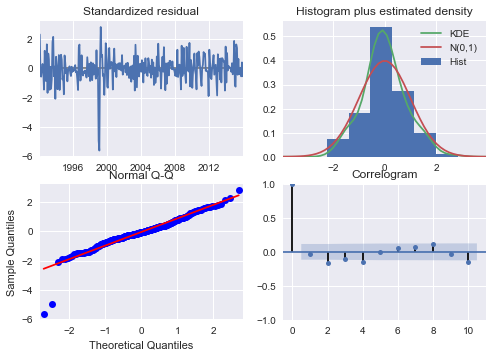

In [30]:
# SARIMA(1,1,1)x(1,1,1)_12

model7_111=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings_log['Metric_Tons'],order=(1,1,1),seasonal_order=(1,1,1,12),trend='ct',enforce_invertibility=False)
results7=model7_111.fit()
print(results7.summary())

#Saving the order, AIC, BIC results
ar3 = results7.model_orders['ar']
ma3 = results7.model_orders['ma']
AIC3 = results7.aic
BIC3 = results7.bic

order_aic_bic1.loc[len(order_aic_bic1)] = [ar3, ma3, AIC3, BIC3]

print(order_aic_bic1)

#Plot residual diagnostics
results7.plot_diagnostics();

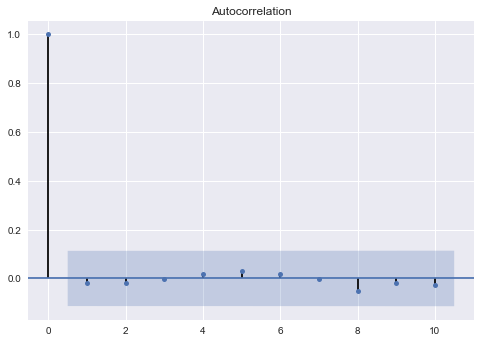

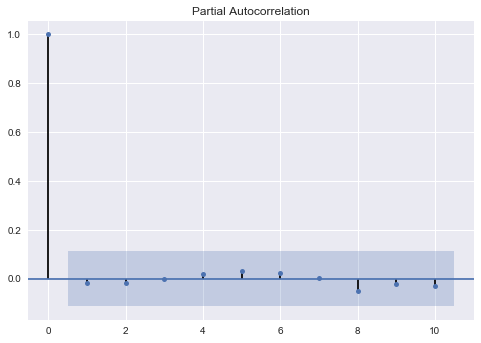

In [31]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(results7.resid, lags=10);
sm.graphics.tsa.plot_pacf(results7.resid, lags=10);

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        Metric_Tons   No. Observations:                  300
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -15.761
Date:                            Tue, 18 Feb 2020   AIC                             43.523
Time:                                    00:41:29   BIC                             65.479
Sample:                                01-01-1991   HQIC                            52.322
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0015      0.018      0.082      0.935      -0.034       0.037
drift      -1.495e-05      0.000   

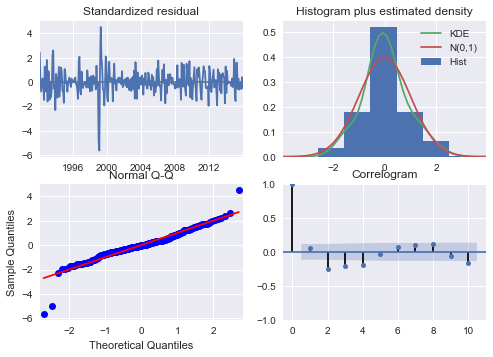

In [32]:
# SARIMA(0,1,1)x(1,1,1)_12

model8_011=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings_log['Metric_Tons'],order=(0,1,1),seasonal_order=(1,1,1,12),trend='ct',enforce_invertibility=False)
results8=model8_011.fit()
print(results8.summary())

#Saving the order, AIC, BIC results
ar4 = results8.model_orders['ar']
ma4 = results8.model_orders['ma']
AIC4 = results8.aic
BIC4 = results8.bic

order_aic_bic1.loc[len(order_aic_bic1)] = [ar4, ma4, AIC4, BIC4]

print(order_aic_bic1)

#Plot residual diagnostics
results8.plot_diagnostics();

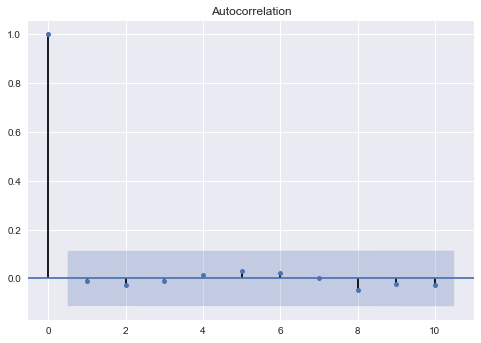

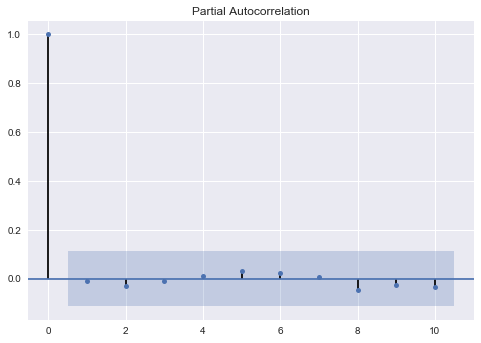

In [33]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(results8.resid, lags=10);
sm.graphics.tsa.plot_pacf(results8.resid, lags=10);

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        Metric_Tons   No. Observations:                  300
Model:             SARIMAX(0, 1, 2)x(1, 1, 1, 12)   Log Likelihood                  10.098
Date:                            Tue, 18 Feb 2020   AIC                             -6.196
Time:                                    00:41:32   BIC                             19.420
Sample:                                01-01-1991   HQIC                             4.070
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0035      0.008     -0.431      0.666      -0.019       0.012
drift       1.513e-05   4.51e-05   

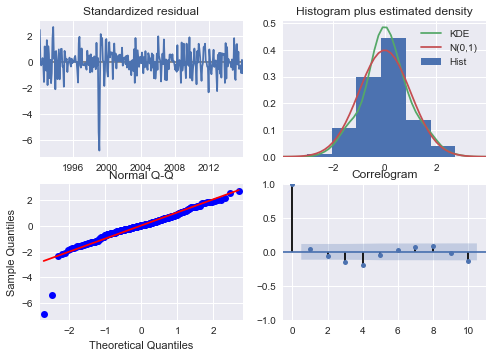

In [34]:
# SARIMA(0,1,2)x(1,1,1)_12

model9_012=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings_log['Metric_Tons'],order=(0,1,2),seasonal_order=(1,1,1,12),trend='ct',enforce_invertibility=False)
results9=model9_012.fit()
print(results9.summary())

#Saving the order, AIC, BIC results
ar5 = results9.model_orders['ar']
ma5 = results9.model_orders['ma']
AIC5 = results9.aic
BIC5 = results9.bic

order_aic_bic1.loc[len(order_aic_bic1)] = [ar5, ma5, AIC5, BIC5]

print(order_aic_bic1)

#Plot residual diagnostics
results9.plot_diagnostics();

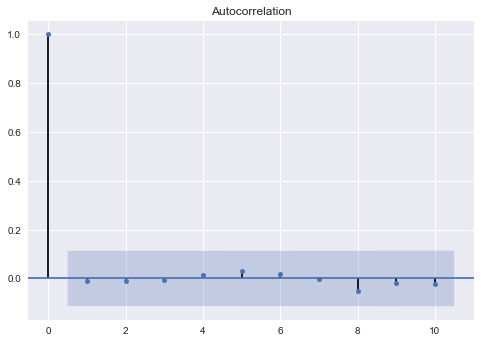

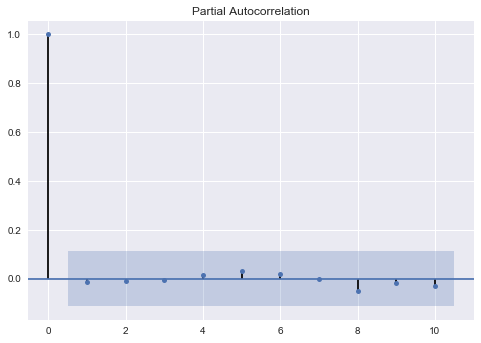

In [35]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(results9.resid, lags=10);
sm.graphics.tsa.plot_pacf(results9.resid, lags=10);

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        Metric_Tons   No. Observations:                  300
Model:             SARIMAX(4, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   7.495
Date:                            Tue, 18 Feb 2020   AIC                              5.010
Time:                                    00:41:34   BIC                             41.604
Sample:                                01-01-1991   HQIC                            19.676
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.021      0.023      0.982      -0.041       0.042
drift      -1.003e-05      0.000   

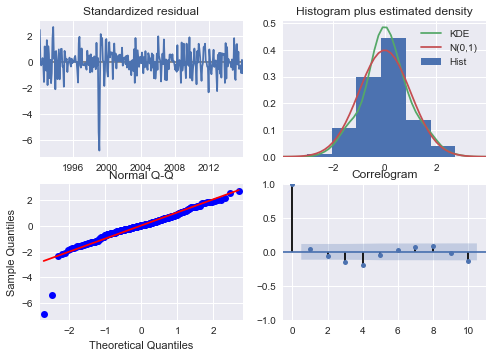

In [36]:
# SARIMA(4,1,1)x(1,1,1)_12

model10_411=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings_log['Metric_Tons'],order=(4,1,1),seasonal_order=(1,1,1,12),trend='ct',enforce_invertibility=False)
results10=model10_411.fit()
print(results10.summary())

#Saving the order, AIC, BIC results
ar6 = results10.model_orders['ar']
ma6 = results10.model_orders['ma']
AIC6 = results10.aic
BIC6 = results10.bic

order_aic_bic1.loc[len(order_aic_bic1)] = [ar6, ma6, AIC6, BIC6]

print(order_aic_bic1)

#Plot residual diagnostics
results9.plot_diagnostics();

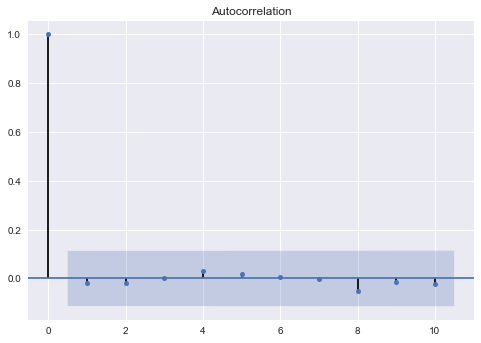

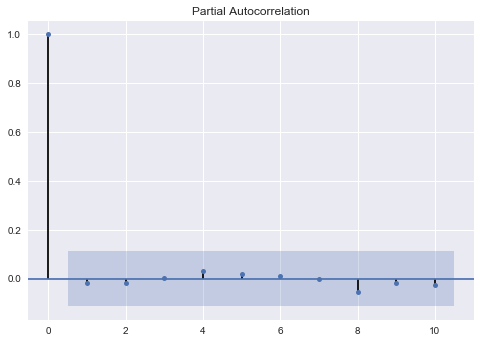

In [37]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(results10.resid, lags=10);
sm.graphics.tsa.plot_pacf(results10.resid, lags=10);

In [38]:
#Sorting the results by AIC and BIC scores

# Sort by AIC
print(order_aic_bic1.sort_values('AIC'))

# Sort by BIC
print(order_aic_bic1.sort_values('BIC'))

#As per the AIC/BIC values, the best model is SARIMA(0,1,2)x(1,1,1)_12, it also has not bad residuals
#Second best is SARIMA(4,1,1)x(1,1,1)_12 and next is SARIMA(1,1,1)x(1,1,1)_12

#Proceeding to forecast with these

     p    q        AIC        BIC
4  0.0  2.0  -6.196348  19.420027
5  4.0  1.0   5.009630  41.604452
2  1.0  1.0  11.706073  37.322449
1  2.0  1.0  12.527200  41.803058
0  3.0  1.0  28.068854  61.004194
3  0.0  1.0  43.522509  65.479403
     p    q        AIC        BIC
4  0.0  2.0  -6.196348  19.420027
2  1.0  1.0  11.706073  37.322449
5  4.0  1.0   5.009630  41.604452
1  2.0  1.0  12.527200  41.803058
0  3.0  1.0  28.068854  61.004194
3  0.0  1.0  43.522509  65.479403


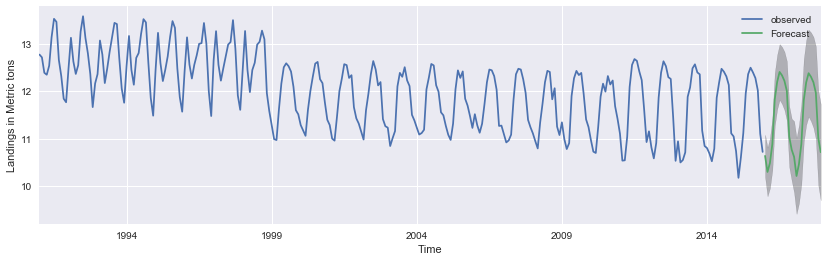

In [39]:
#Forecast with SARIMA(0,1,2)x(1,1,1)_12

pred_uc = results9.get_forecast(steps=24)
pred_ci = pred_uc.conf_int()
ax = NMFS_Landings_log['Metric_Tons'].plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Time')
ax.set_ylabel('Landings in Metric tons')
plt.legend()
plt.show()

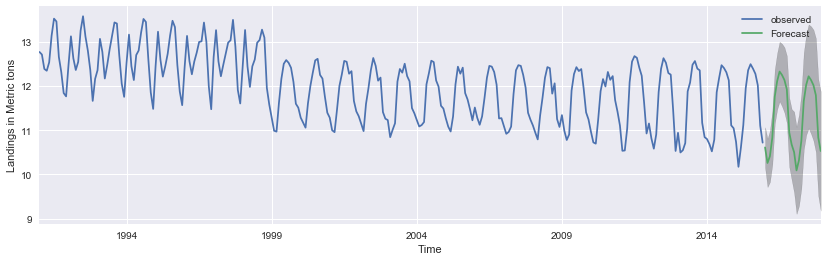

In [40]:
#Forecast with SARIMA(4,1,1)x(1,1,1)_12

pred_uc = results10.get_forecast(steps=24)
pred_ci = pred_uc.conf_int()
ax = NMFS_Landings_log['Metric_Tons'].plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Time')
ax.set_ylabel('Landings in Metric tons')
plt.legend()
plt.show()

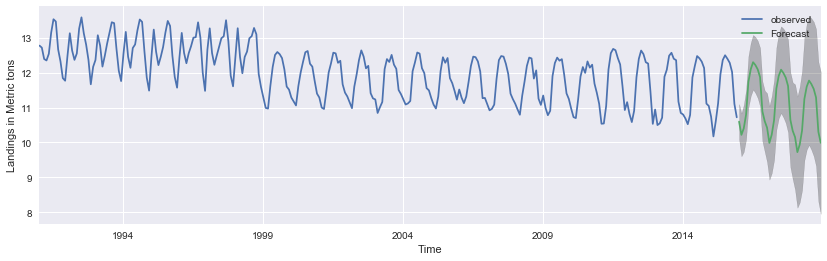

In [41]:
#Forecast with SARIMA(1,1,1)x(1,1,1)_12

pred_uc = results7.get_forecast(steps=36)
pred_ci = pred_uc.conf_int()
ax = NMFS_Landings_log['Metric_Tons'].plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Time')
ax.set_ylabel('Landings in Metric tons')
plt.legend()
plt.show()

In [42]:
# ------------- Taking the first 8 years of data as the first part. -----------------

NMFS_Landings_first = NMFS_Landings[0:96]

NMFS_Landings_first.tail()


,Metric_Tons
Time,
1998-08-01,460376.7
1998-09-01,582003.9
1998-10-01,485751.1
1998-11-01,156128.7
1998-12-01,107050.7


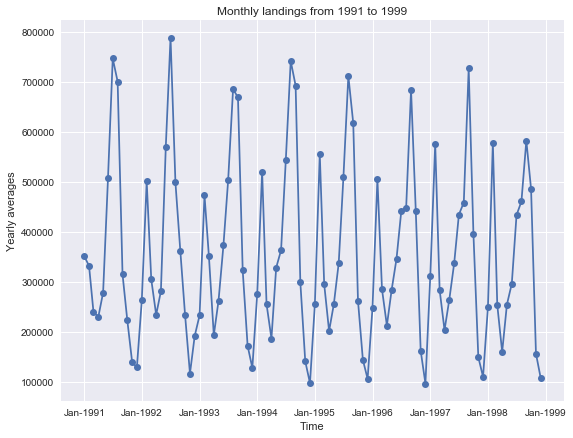

In [43]:
#Plotting the time series data

plt.style.use('seaborn')

fig,ax=plt.subplots(figsize=(9,7))
ax.plot(NMFS_Landings_first.index.values, NMFS_Landings_first['Metric_Tons'],'-o')
ax.set(xlabel="Time",ylabel="Yearly averages",title="Monthly landings from 1991 to 1999")

#Setting the ticks format on x-axis to months and years
ax.xaxis.set_major_formatter(DateFormatter("%b-%Y"))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


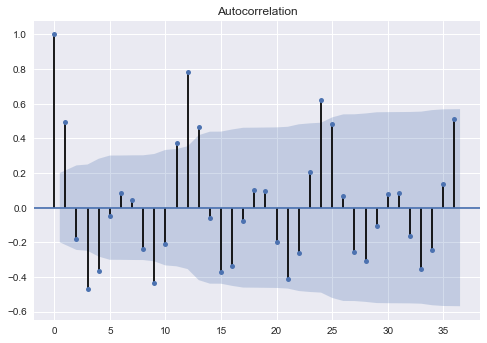

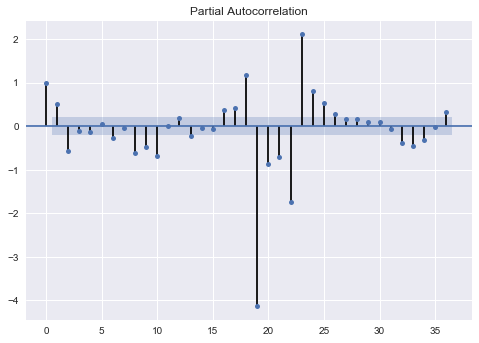

In [44]:
#Creating the ACF and PACF plots of the first part of the series

sm.graphics.tsa.plot_acf(NMFS_Landings_first.Metric_Tons, lags=36);
sm.graphics.tsa.plot_pacf(NMFS_Landings_first.Metric_Tons, lags=36);

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                            Statespace Model Results                            
Dep. Variable:              Metric_Tons   No. Observations:                   96
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood               -1070.086
Date:                  Tue, 18 Feb 2020   AIC                           2146.172
Time:                          00:41:36   BIC                           2153.465
Sample:                      01-01-1991   HQIC                          2149.104
                           - 12-01-1998                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9457.0867   1.94e+04      0.488      0.626   -2.85e+04    4.74e+04
drift       -225.2518    411.675     -0.547      0.584   -1032.120     581.616
sigma2        6.8e+09    6.1e+08    

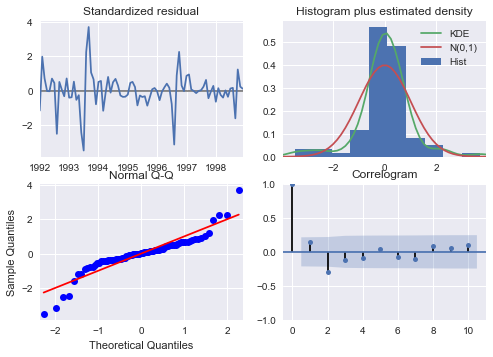

In [45]:
# Start with the first seasonal difference

model1_1=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings_first['Metric_Tons'],order=(0,0,0),seasonal_order=(0,1,0,12),trend='ct',enforce_invertibility=False)
results1_1=model1_1.fit()
print(results1_1.summary())

results1_1.plot_diagnostics();

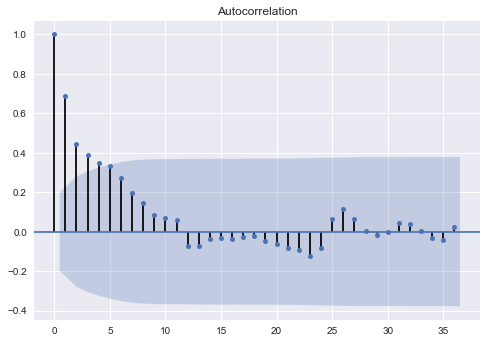

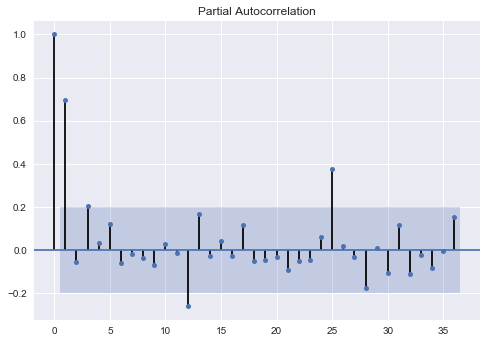

In [46]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(results1_1.resid, lags=36);
sm.graphics.tsa.plot_pacf(results1_1.resid, lags=36);

# We got rid of seasonal effect as there is no significant correlation at seasonal lags in ACF and PACF both. 
# We have a declining pattern in ACF and three significant correlations in PACF. Hence, the data doesn't look stationary 
# and might require a differencing.


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        Metric_Tons   No. Observations:                   96
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -1079.847
Date:                            Tue, 18 Feb 2020   AIC                           2165.694
Time:                                    00:41:37   BIC                           2172.951
Sample:                                01-01-1991   HQIC                          2168.610
                                     - 12-01-1998                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4268.8592   2.56e+04      0.167      0.868    -4.6e+04    5.45e+04
drift        -76.9261    484.962   

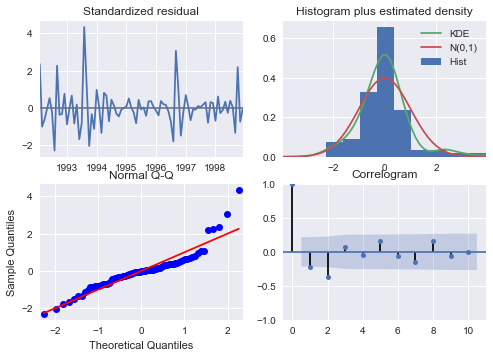

In [47]:
#Trying the first order normal differencing along with the first seasonal differencing

model1_2=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings_first['Metric_Tons'],order=(0,1,0),seasonal_order=(0,1,0,12),trend='ct',enforce_invertibility=False)
results1_2=model1_2.fit()
print(results1_2.summary())

results1_2.plot_diagnostics();

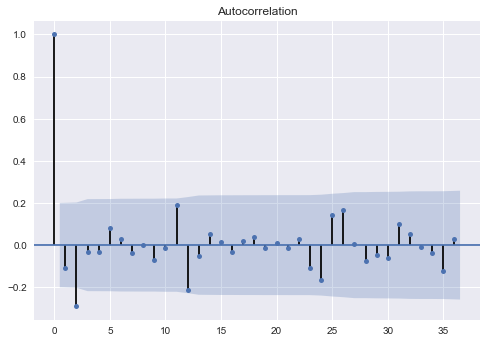

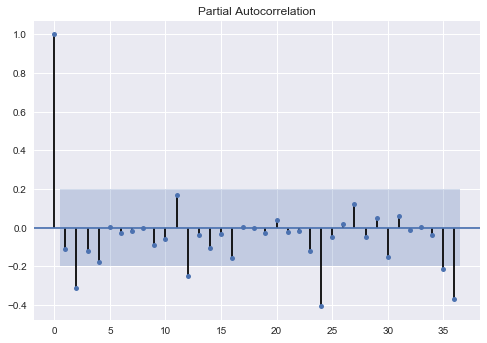

In [48]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(results1_2.resid, lags=36);
sm.graphics.tsa.plot_pacf(results1_2.resid, lags=36);

# We got rid of the trend that was seen. There is one significant lag in the ACF and one significant lag 
# in the PACF plot. There are seasonal significant lags in PACF as well.


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        Metric_Tons   No. Observations:                   96
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood               -1076.761
Date:                            Tue, 18 Feb 2020   AIC                           2161.523
Time:                                    00:41:38   BIC                           2171.198
Sample:                                01-01-1991   HQIC                          2165.410
                                     - 12-01-1998                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4268.8592   1.94e+04      0.220      0.826   -3.37e+04    4.23e+04
drift        -76.9261    396.875   

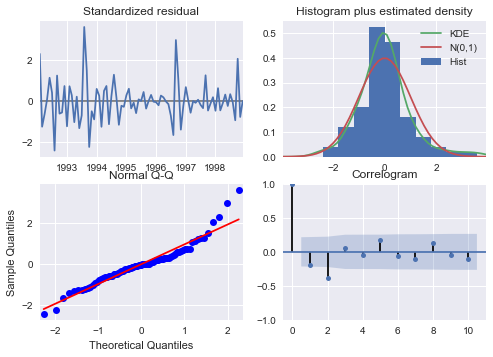

In [49]:
# Since the PACF shows significant seasonal lags, trying the seasonal MA1 component with seasonal differencing.

model1_3=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings_first['Metric_Tons'],order=(0,1,0),seasonal_order=(0,1,1,12),trend='ct',enforce_invertibility=False)
results1_3=model1_3.fit()
print(results1_3.summary())

results1_3.plot_diagnostics();

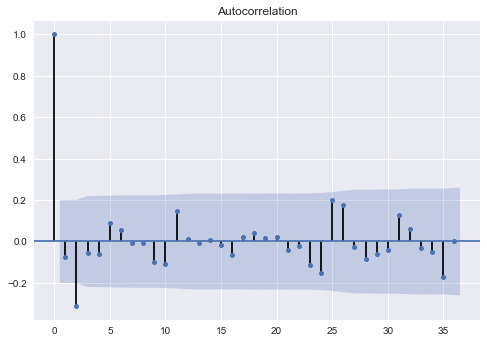

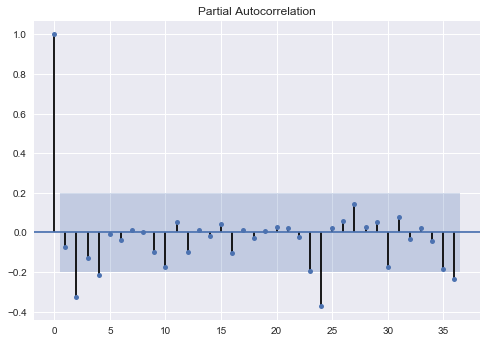

In [50]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(results1_3.resid, lags=36);
sm.graphics.tsa.plot_pacf(results1_3.resid, lags=36);

# We got rid of seasonal effect as there are no significant correlations at seasonal lags in ACF and PACF both.
# And there is no sign of an ordinary trend as well. So we will go on with specification of ARMA component. 


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        Metric_Tons   No. Observations:                   96
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1064.125
Date:                            Tue, 18 Feb 2020   AIC                           2138.251
Time:                                    00:41:39   BIC                           2150.345
Sample:                                01-01-1991   HQIC                          2143.110
                                     - 12-01-1998                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1895.6222   7161.827     -0.265      0.791   -1.59e+04    1.21e+04
drift         31.4567    138.695   

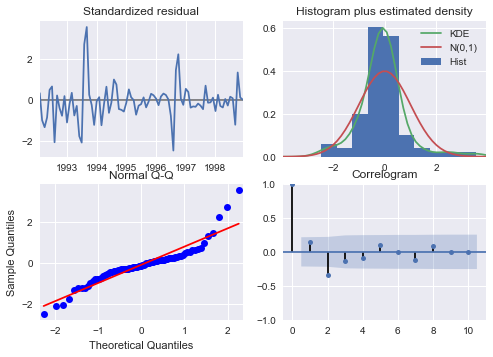

In [51]:
# Trying the ARMA (0,1) with the seasonal SMA1 order.

model1_4=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings_first['Metric_Tons'],order=(0,1,1),seasonal_order=(0,1,1,12),trend='ct',enforce_invertibility=False)
results1_4=model1_4.fit()
print(results1_4.summary())

results1_4.plot_diagnostics();

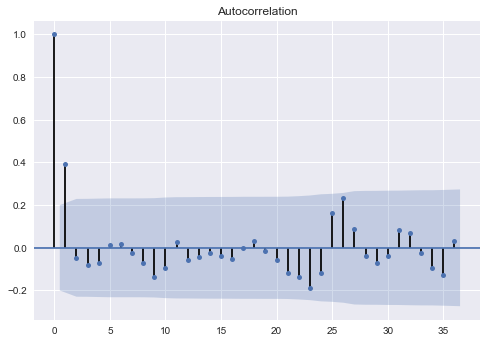

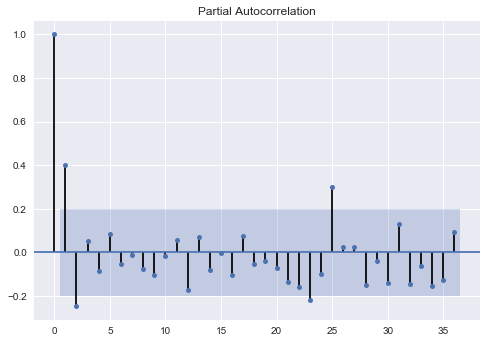

In [52]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(results1_4.resid, lags=36);
sm.graphics.tsa.plot_pacf(results1_4.resid, lags=36);



/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        Metric_Tons   No. Observations:                   96
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 12)   Log Likelihood               -1058.183
Date:                            Tue, 18 Feb 2020   AIC                           2128.366
Time:                                    00:41:41   BIC                           2142.879
Sample:                                01-01-1991   HQIC                          2134.196
                                     - 12-01-1998                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -8839.7461   3651.022     -2.421      0.015    -1.6e+04   -1683.875
drift        137.1459     63.966   

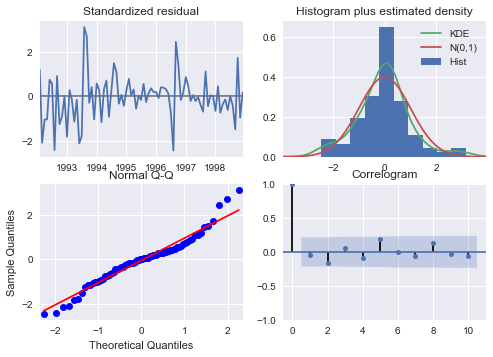

In [53]:
# We try the ARMA (0,2) and ARMA (1,1) along with SMA1 as overfitting models.

model1_5=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings_first['Metric_Tons'],order=(0,1,2),seasonal_order=(0,1,1,12),trend='ct',enforce_invertibility=False)
results1_5=model1_5.fit()
print(results1_5.summary())

results1_5.plot_diagnostics();

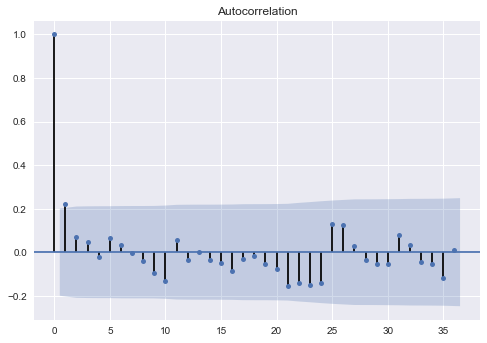

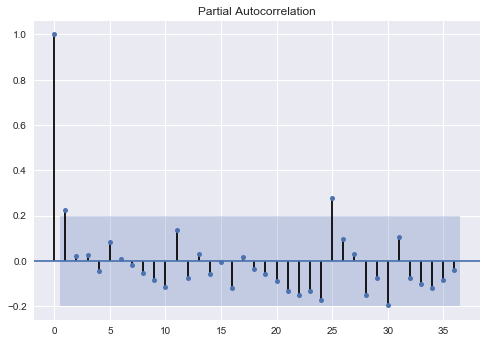

In [54]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(results1_5.resid, lags=36);
sm.graphics.tsa.plot_pacf(results1_5.resid, lags=36);

# We got rid of seasonal effect as there is no significant correlation at seasonal lags in ACF and PACF both.
# And there is no sign of an ordinary trend as well. We got white noise series with the ARMA (2,1) component.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        Metric_Tons   No. Observations:                   96
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1062.735
Date:                            Tue, 18 Feb 2020   AIC                           2137.471
Time:                                    00:41:42   BIC                           2151.984
Sample:                                01-01-1991   HQIC                          2143.301
                                     - 12-01-1998                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1866.7171   7953.332     -0.235      0.814   -1.75e+04    1.37e+04
drift         25.1006    129.681   

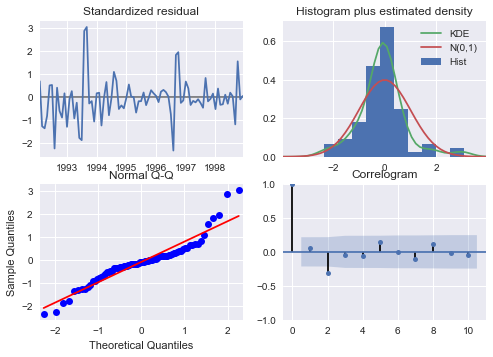

In [55]:
model1_6=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings_first['Metric_Tons'],order=(1,1,1),seasonal_order=(0,1,1,12),trend='ct',enforce_invertibility=False)
results1_6=model1_6.fit()
print(results1_6.summary())

results1_6.plot_diagnostics();

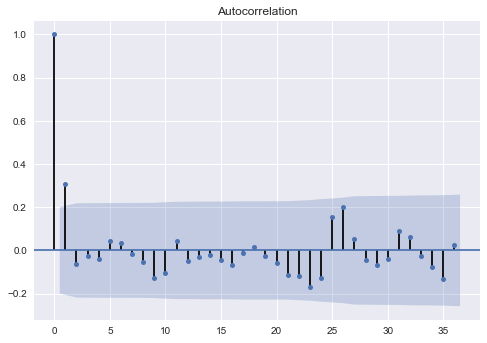

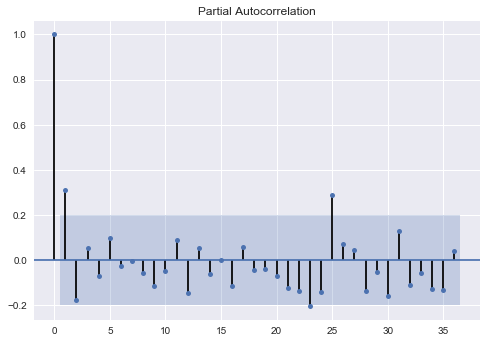

In [56]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(results1_6.resid, lags=36);
sm.graphics.tsa.plot_pacf(results1_6.resid, lags=36);

# We got rid of seasonal effect as there is no significant correlation at seasonal lags in ACF and PACF both.
# And there is no sign of an ordinary trend as well. We got almost white noise series with the ARMA (2,1) component.

In [57]:
# All components are significant and best residuals are obtained with the ARIMA (0,1,2) model

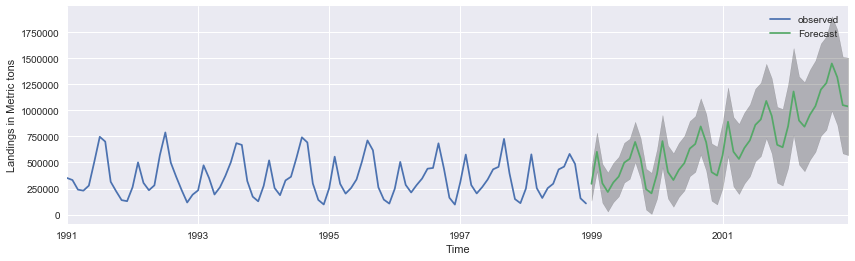

In [58]:
# We proceed to forecast using the SARIMA (0,1,2) x (0,1,1)_12 model

pred_uc = results1_5.get_forecast(steps=48)
pred_ci = pred_uc.conf_int()
ax = NMFS_Landings_first['Metric_Tons'].plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Time')
ax.set_ylabel('Landings in Metric tons')
plt.legend()
plt.show()

In [59]:
# ------------- Taking the last 8 years of data as the second part -----------------

NMFS_Landings_second = NMFS_Landings[96:300]

NMFS_Landings_second.tail()


,Metric_Tons
Time,
2015-08-01,241211.8
2015-09-01,214366.8
2015-10-01,165268.8
2015-11-01,66215.2
2015-12-01,45262.2


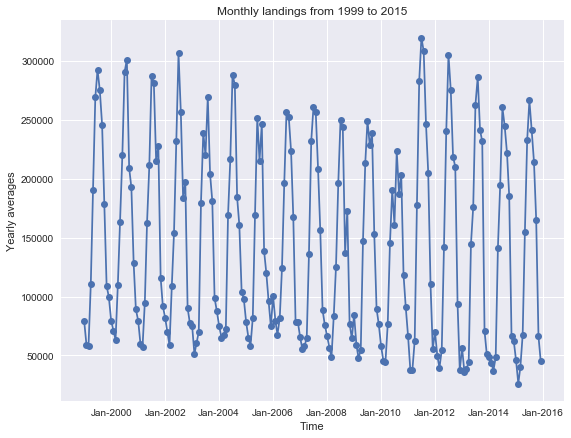

In [60]:
#Plotting the time series data

plt.style.use('seaborn')

fig,ax=plt.subplots(figsize=(9,7))
ax.plot(NMFS_Landings_second.index.values, NMFS_Landings_second['Metric_Tons'],'-o')
ax.set(xlabel="Time",ylabel="Yearly averages",title="Monthly landings from 1999 to 2015")

#Setting the ticks format on x-axis to months and years
ax.xaxis.set_major_formatter(DateFormatter("%b-%Y"))

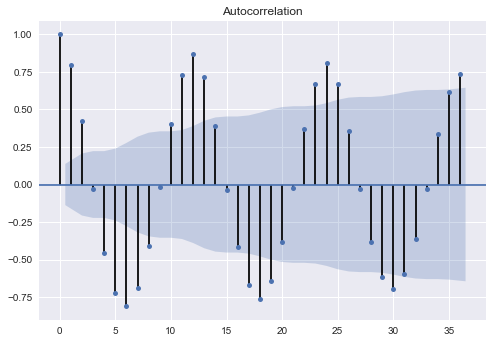

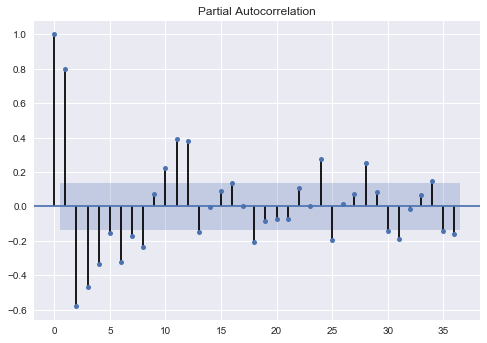

In [61]:
#Creating the ACF and PACF plots of the first part of the series

sm.graphics.tsa.plot_acf(NMFS_Landings_second.Metric_Tons, lags=36);
sm.graphics.tsa.plot_pacf(NMFS_Landings_second.Metric_Tons, lags=36);

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                            Statespace Model Results                            
Dep. Variable:              Metric_Tons   No. Observations:                   96
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood               -1070.086
Date:                  Tue, 18 Feb 2020   AIC                           2146.172
Time:                          00:41:43   BIC                           2153.465
Sample:                      01-01-1991   HQIC                          2149.104
                           - 12-01-1998                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9457.0867   1.94e+04      0.488      0.626   -2.85e+04    4.74e+04
drift       -225.2518    411.675     -0.547      0.584   -1032.120     581.616
sigma2        6.8e+09    6.1e+08    

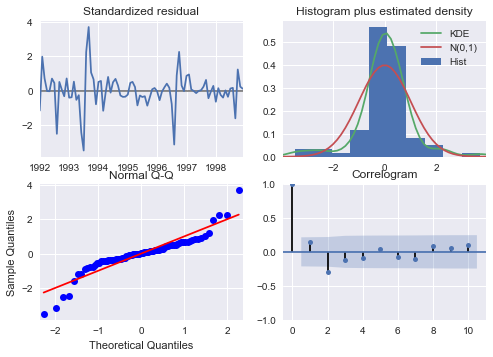

In [62]:
# Start with the first seasonal difference

model2_1=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings_second['Metric_Tons'],order=(0,0,0),seasonal_order=(0,1,0,12),trend='ct',enforce_invertibility=False)
results2_1=model1_1.fit()
print(results2_1.summary())

results2_1.plot_diagnostics();

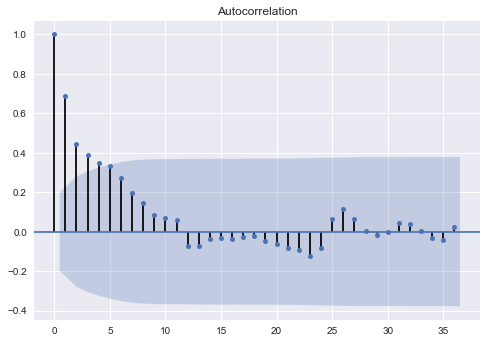

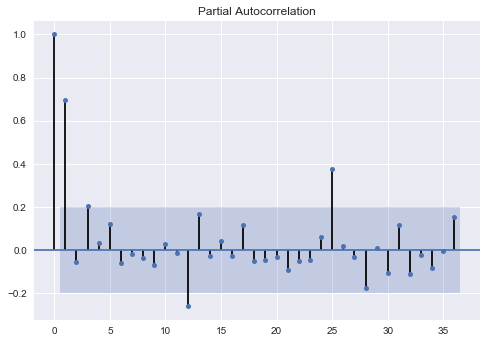

In [63]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(results2_1.resid, lags=36);
sm.graphics.tsa.plot_pacf(results2_1.resid, lags=36);

# We got rid of seasonal effect as there is no significant correlation at seasonal lags in ACF and PACF both. 
# We have a declining pattern in ACF and three significant correlations in PACF. Hence, the data doesn't look stationary 
# and might require a differencing.


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        Metric_Tons   No. Observations:                  204
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -2270.122
Date:                            Tue, 18 Feb 2020   AIC                           4546.244
Time:                                    00:41:44   BIC                           4556.001
Sample:                                01-01-1999   HQIC                          4550.196
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    112.9087   6542.681      0.017      0.986   -1.27e+04    1.29e+04
drift         -2.1347     56.399   

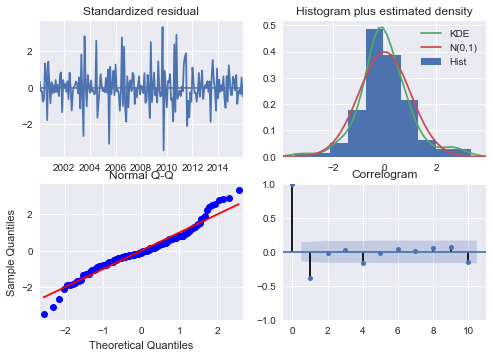

In [64]:
#Trying the first order normal differencing along with the first seasonal differencing

model2_2=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings_second['Metric_Tons'],order=(0,1,0),seasonal_order=(0,1,0,12),trend='ct',enforce_invertibility=False)
results2_2=model2_2.fit()
print(results2_2.summary())

results2_2.plot_diagnostics();

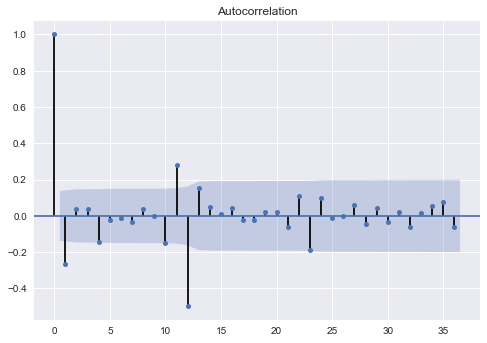

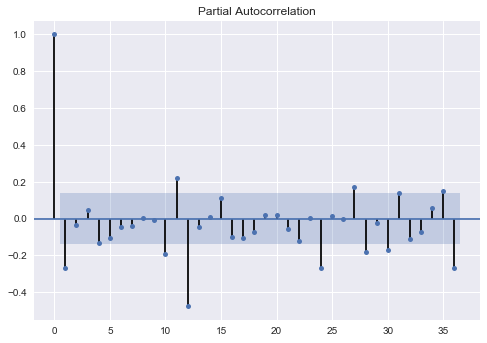

In [65]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(results2_2.resid, lags=36);
sm.graphics.tsa.plot_pacf(results2_2.resid, lags=36);

# We got rid of the trend that was seen. There are two significant lags in the ACF which are seasonal 
# and three significant seasonal lags in the PACF plot which could indicate an SMA1 model.


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        Metric_Tons   No. Observations:                  204
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood               -2233.709
Date:                            Tue, 18 Feb 2020   AIC                           4475.419
Time:                                    00:41:45   BIC                           4488.428
Sample:                                01-01-1999   HQIC                          4480.688
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    112.9087   2642.508      0.043      0.966   -5066.311    5292.129
drift         -2.1346     25.620   

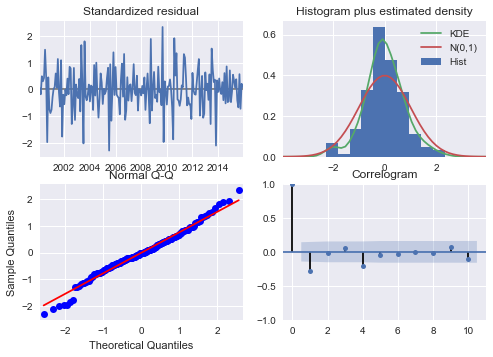

In [66]:
# Since the PACF shows significant seasonal lags, trying the seasonal MA1 component with seasonal differencing.

model2_3=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings_second['Metric_Tons'],order=(0,1,0),seasonal_order=(0,1,1,12),trend='ct',enforce_invertibility=False)
results2_3=model2_3.fit()
print(results2_3.summary())

results2_3.plot_diagnostics();

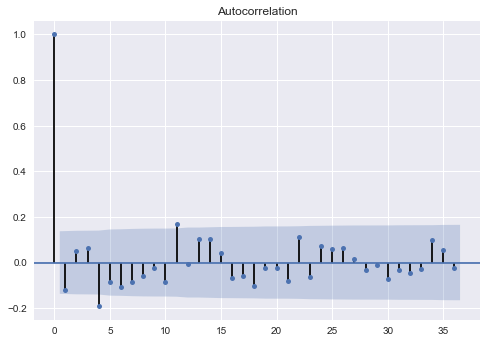

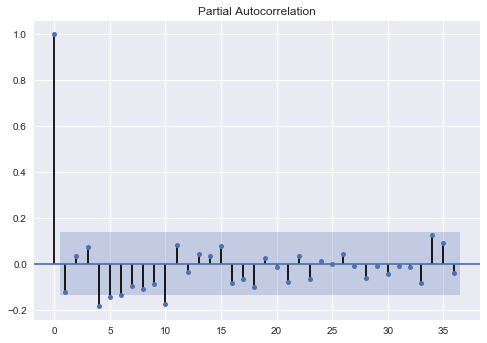

In [67]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(results2_3.resid, lags=36);
sm.graphics.tsa.plot_pacf(results2_3.resid, lags=36);

# We got rid of seasonal effect as there is no significant correlation at seasonal lags in ACF and PACF both.
# And there is no sign of an ordinary trend as well. So we will go on with specification of ARMA component. 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        Metric_Tons   No. Observations:                  204
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2218.443
Date:                            Tue, 18 Feb 2020   AIC                           4448.886
Time:                                    00:41:47   BIC                           4468.399
Sample:                                01-01-1999   HQIC                          4456.789
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     25.6357    640.132      0.040      0.968   -1229.001    1280.272
drift         -0.7192      5.958   

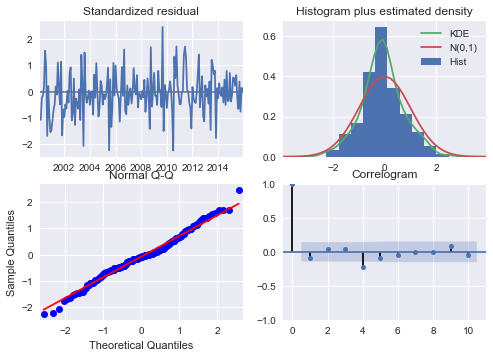

In [68]:
# Trying the ARMA (1,1) with the seasonal SMA1 order.

model2_4=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings_second['Metric_Tons'],order=(1,1,1),seasonal_order=(0,1,1,12),trend='ct',enforce_invertibility=False)
results2_4=model2_4.fit()
print(results2_4.summary())

results2_4.plot_diagnostics();

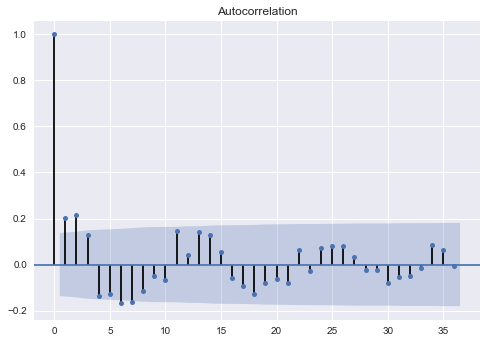

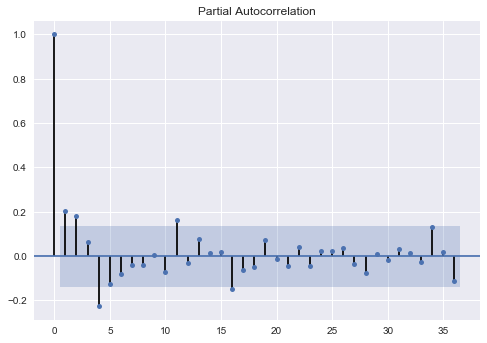

In [69]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(results2_4.resid, lags=36);
sm.graphics.tsa.plot_pacf(results2_4.resid, lags=36);

# Almost white noise series is obtained.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        Metric_Tons   No. Observations:                  204
Model:             SARIMAX(1, 1, 2)x(0, 1, 1, 12)   Log Likelihood               -2217.370
Date:                            Tue, 18 Feb 2020   AIC                           4448.740
Time:                                    00:41:49   BIC                           4471.506
Sample:                                01-01-1999   HQIC                          4457.961
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    941.2322   2871.139      0.328      0.743   -4686.097    6568.561
drift         -8.5352     26.979   

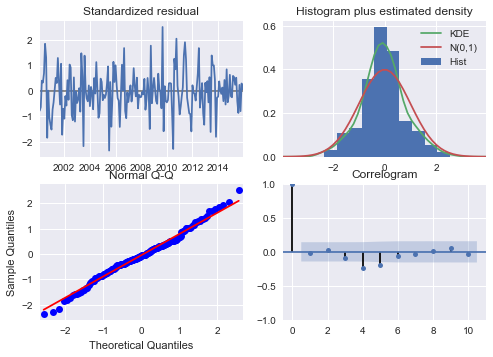

In [70]:
# Trying the ARMA (1,2) with the seasonal SMA1 order.

model2_5=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings_second['Metric_Tons'],order=(1,1,2),seasonal_order=(0,1,1,12),trend='ct',enforce_invertibility=False)
results2_5=model2_5.fit()
print(results2_5.summary())

results2_5.plot_diagnostics();

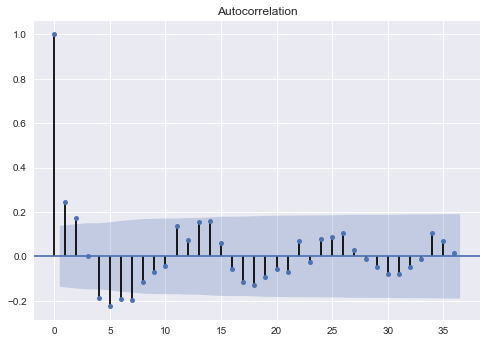

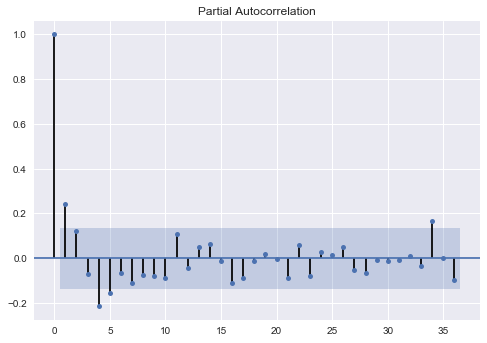

In [71]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(results2_5.resid, lags=36);
sm.graphics.tsa.plot_pacf(results2_5.resid, lags=36);

# There are some significant lags with the ACF plot but otherwise the plots look fine.

In [72]:
# The SARIMA (1,1,1)x(0,1,1)_12 model is slightly better in terms of residuals 

# We can try overfitting model ARIMA (2,1,1) as alternative - ARIMA (1,1,2) has been attempted

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        Metric_Tons   No. Observations:                  204
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2217.731
Date:                            Tue, 18 Feb 2020   AIC                           4449.463
Time:                                    00:41:50   BIC                           4472.229
Sample:                                01-01-1999   HQIC                          4458.684
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     25.3043    548.110      0.046      0.963   -1048.971    1099.580
drift         -0.6038      5.141   

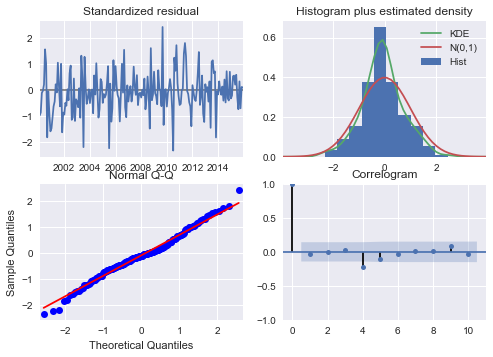

In [73]:
# Trying the ARMA (2,2) with the seasonal SMA1 order.

model2_6=sm.tsa.statespace.SARIMAX(endog=NMFS_Landings_second['Metric_Tons'],order=(2,1,1),seasonal_order=(0,1,1,12),trend='ct',enforce_invertibility=False)
results2_6=model2_6.fit()
print(results2_6.summary())

results2_6.plot_diagnostics();

#AR2 component is not significant here

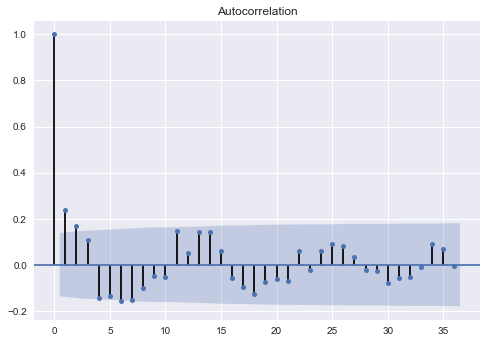

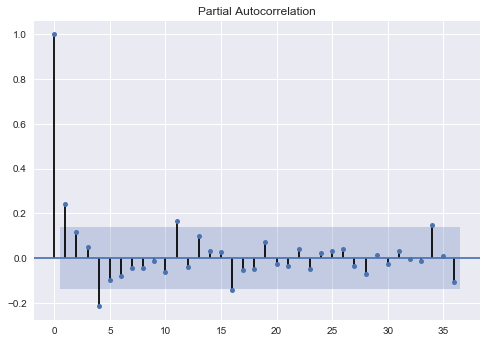

In [74]:
#To visualise the ACF, PACF plots separately, the manual codes can be used

#Creating the ACF and PACF plots of the residual series

sm.graphics.tsa.plot_acf(results2_6.resid, lags=36);
sm.graphics.tsa.plot_pacf(results2_6.resid, lags=36);

# We got rid of seasonal effect as there is no significant correlation at seasonal lags in ACF and PACF both.
# And there is no sign of an ordinary trend as well. We got white noise series with the ARMA (2,1) component.

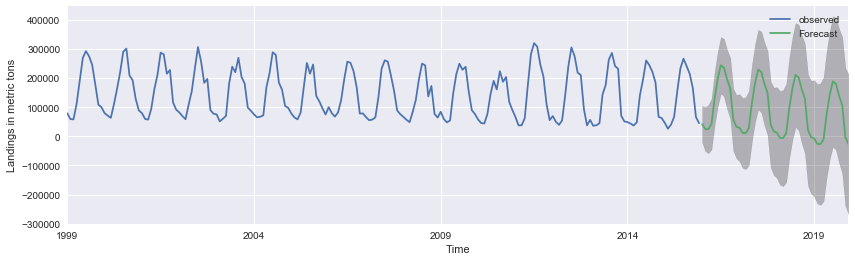

In [75]:
# We proceed to forecast using the SARIMA (1,1,1) x (0,1,1)_12 model

pred_uc = results2_4.get_forecast(steps=48)
pred_ci = pred_uc.conf_int()
ax = NMFS_Landings_second['Metric_Tons'].plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Time')
ax.set_ylabel('Landings in metric tons')
plt.legend()
plt.show()